# Lab 2: Clustering

The goal of this lab session is to code a clustering algorithm, apply it to data and compare the performance with other techniques.

You have to send the filled notebook named **"L2_familyname1_familyname2.ipynb"** (groups of 2) by email to aml.centralesupelec.2019@gmail.com by October 9, 2019. Please put **"AML-L2"** in the subject. 

We begin with the standard imports:

In [8]:
import numpy as np
import time
import matplotlib.pyplot as plt
import seaborn as sns
import sklearn.cluster as cluster # all clustering techniques except hdbscan
%matplotlib inline
sns.set_context('poster')
#sns.set_color_codes()
plot_kwds = {'alpha' : 0.5, 's' : 80, 'linewidths':0}

We will have two toy datasets to try the different methods:

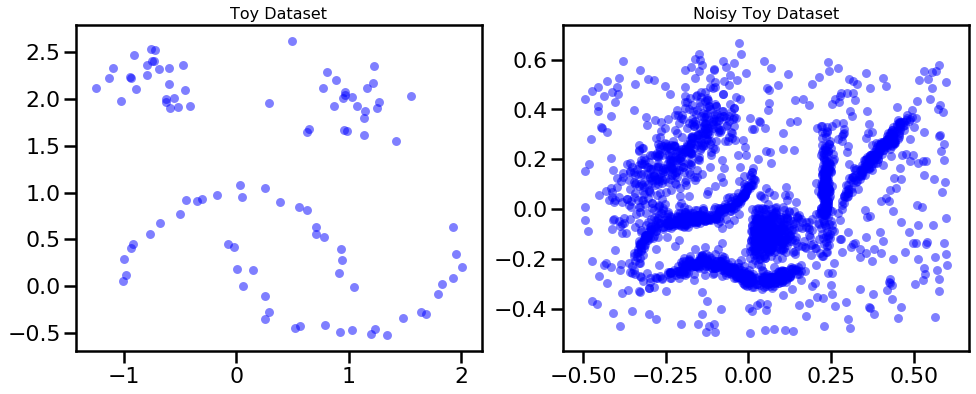

In [9]:
import sklearn.datasets as data
moons, _ = data.make_moons(n_samples=50, noise=0.05)
blobs, _ = data.make_blobs(n_samples=50, centers=[(-0.75,2.25), (1.0, 2.0)], cluster_std=0.25)
test_data_0 = np.vstack([moons, blobs])

test_data_1 = np.load('clusterable_data-1.npy')

fig, ax = plt.subplots(1, 2, figsize=(16, 6))
ax[0].scatter(test_data_0.T[0], test_data_0.T[1], c='b', **plot_kwds)
ax[0].set_title('Toy Dataset', size=16)

ax[1].scatter(test_data_1.T[0], test_data_1.T[1], color='b', **plot_kwds)
ax[1].set_title('Noisy Toy Dataset', size=16)

plt.show();

There are a lot of clustering algorithms to choose from the `sklearn` library. So what clustering algorithms should you be using? It depends.

## K-means

K-Means is the 'go-to' clustering algorithm for many simply because it is fast, easy to understand, and available everywhere (there's an implementation in almost any statistical or machine learning tool you care to use). However, K-Means has a few problems caused by its simplicity. 

We try the `sklearn` implementation in our toy datasets:

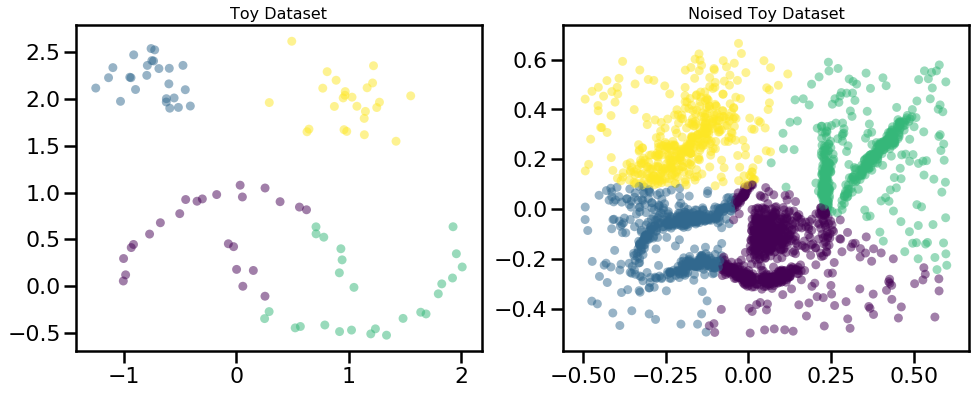

In [10]:
from sklearn.cluster import KMeans
kmeans_0 = KMeans(n_clusters=4, max_iter=200).fit(test_data_0)
kmeans_1 = KMeans(n_clusters=4, max_iter=200).fit(test_data_1)

fig, ax = plt.subplots(1, 2, figsize=(16, 6))
ax[0].scatter(test_data_0.T[0], test_data_0.T[1], c=kmeans_0.labels_ , **plot_kwds)
ax[0].set_title('Toy Dataset', size=16)

ax[1].scatter(test_data_1.T[0], test_data_1.T[1], c=kmeans_1.labels_, **plot_kwds)
ax[1].set_title('Noised Toy Dataset', size=16)


plt.show();

Criticize this technique and its results. This is the reason why we will develop other algorithms performing better.

## Aglomerative Single Linkage clustering

Agglomerative clustering is a suite of algorithms all based on the same idea. The fundamental idea is that you start with each point in it's own cluster and then, for each cluster, use some criterion to choose another cluster to merge with. Do this repeatedly until you have only one cluster and you get get a hierarchy, or binary tree, of clusters branching down to the last layer which has a leaf for each point in the dataset. The most basic version of this, single linkage, chooses the closest cluster to merge, and hence the tree can be ranked by distance as to when clusters merged/split.

**Code your own Aglomerative Single Linkage clustering algorithm**!:

- Fill in the class 
- During the process, keep track of the cluster merges by saving a (num_samples-1,4) np.array being a linkage matrix in scypy format (to use their function to plot dendrogram: `scipy.cluster.hierarchy.dendrogram`). check documentation.

In [11]:
class my_SingleLinkageAglomerativeClustering():
    
    def __init__(self, metric="euclidean", n_clusters=3):
        '''
        Attributes:
        
        metric_: {"euclidean","precomputed"}
            the distance to be used
            if precomputed then X is distance matrix
        n_clusters: integer
            number of clusters to return 
        linkage_matrix_: (n-1, 4) np.array
            in the same format as linkage  
        labels_: integer np.array
            label assigment
        hierarchy_: list of np.array
            each array corresponds to label assigment
            at each level (number of clusters)
            hierarchy_[0]=np.array(list(range(n)))
        '''
        self.metric_ = metric
        self.n_clusters_ = n_clusters
        self.linkage_matrix_ = None
        self.labels_ = None
        self.hierarchy_ = None
        
    def fit(self, X):
        """ Create a hierarchy of clusters
        
        Parameters:
        -----------
        X: (n, p) np.array
            Data matrix
        
        Returns:
        -----
        self: my_SingleLinkageAglomerativeClustering
            to have access to labels_
        """
        # Definition of variables
        n_samples = X.shape[0]
        self.hierarchy_ = [np.array(range(X.shape[0]))]
        self.labels_ = np.array(range(X.shape[0]))
        self.linkage_matrix_ = np.zeros((n_samples - 1, 4))
        
        if not self.metric_ == "precomputed":
            from scipy.spatial.distance import cdist
            Dist = cdist(X, X, self.metric_)
        else:
            Dist = X 
        
        
        # Iteratively create clusters
        itr = 0
        while len(np.unique(self.labels_)) > 1:
            
            idx_min = (np.unique(self.labels_)[0], np.unique(self.labels_)[1])
            min_dist = np.Inf

            for r in np.unique(self.labels_):
                for c in np.unique(self.labels_):
                    if Dist[r, c] < min_dist and Dist[r, c] > 0.:
                        min_dist = Dist[r, c]
                        idx_min = (r, c)
            
            
            cluster1, cluster2 = idx_min # the ones to be merged into a new cluster
            new_cluster = max(self.labels_) + 1
            
            for i in range(len(self.labels_)):
                if self.labels_[i] == cluster1 or self.labels_[i] == cluster2:
                    self.labels_[i] = new_cluster
            
            self.hierarchy_.append(np.copy(self.labels_))
            self.linkage_matrix_[itr, :] = [cluster1, cluster2, min_dist, 
                                            len(list(filter(lambda l: l == new_cluster, self.labels_)))]
            
            New_Dist = np.zeros((Dist.shape[0] + 1,Dist.shape[1] + 1) )
            New_Dist[:-1, :-1] = Dist
            for label in np.unique(self.labels_):
                New_Dist[label, -1] = New_Dist[-1, label] = min([New_Dist[label, cluster1], 
                                                                 New_Dist[label, cluster2]])
            
            Dist = New_Dist
            itr = itr + 1
            
        return self
        
    def plot_dendrogram(self):
        '''Use self.linkage_matrix_ in `scipy.cluster.hierarchy.dendrogram` 
        to plot the dendrogram of the hierarchical structure
        '''
        from scipy.cluster.hierarchy import dendrogram
        dendrogram(self.linkage_matrix_)

Apply the method to our toy datasets

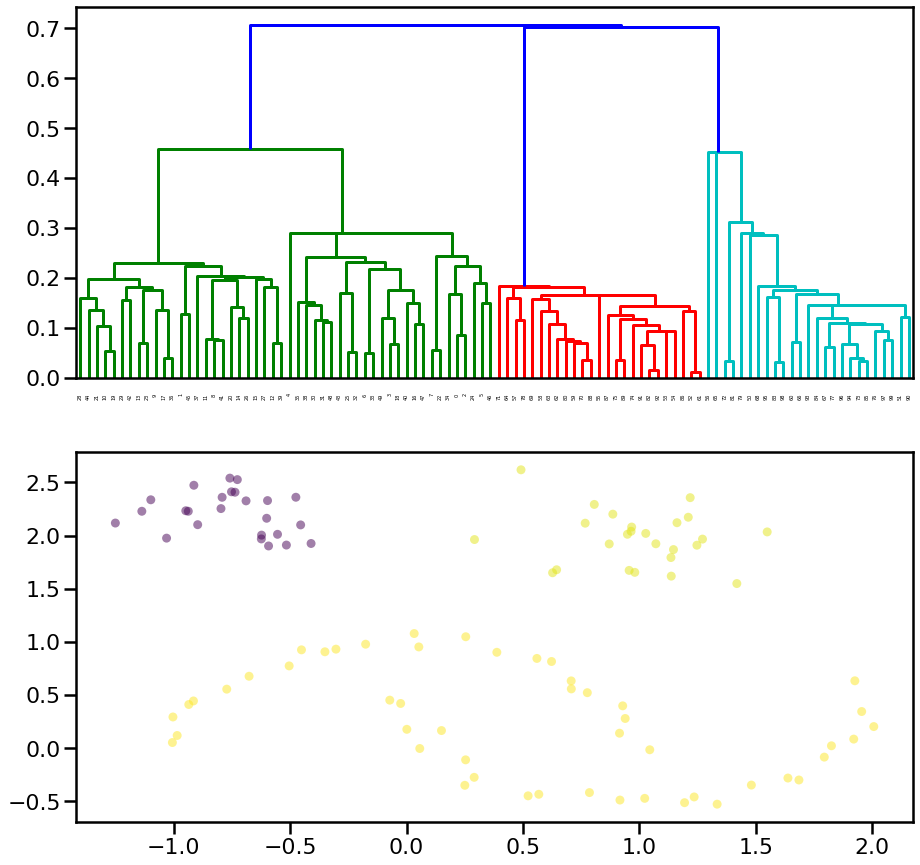

In [12]:
from scipy.spatial import distance 
from scipy.cluster.hierarchy import dendrogram

plt.figure(figsize=(15,15))

plt.subplot(2,1,1)
cluster = my_SingleLinkageAglomerativeClustering()
cluster.fit(test_data_0)
cluster.plot_dendrogram()
plt.subplot(2,1,2)
plt.scatter(test_data_0.T[0], test_data_0.T[1], c=cluster.hierarchy_[-3], **plot_kwds)
plt.show()

Try the different linkage methods implemented in `sklearn`  and comment

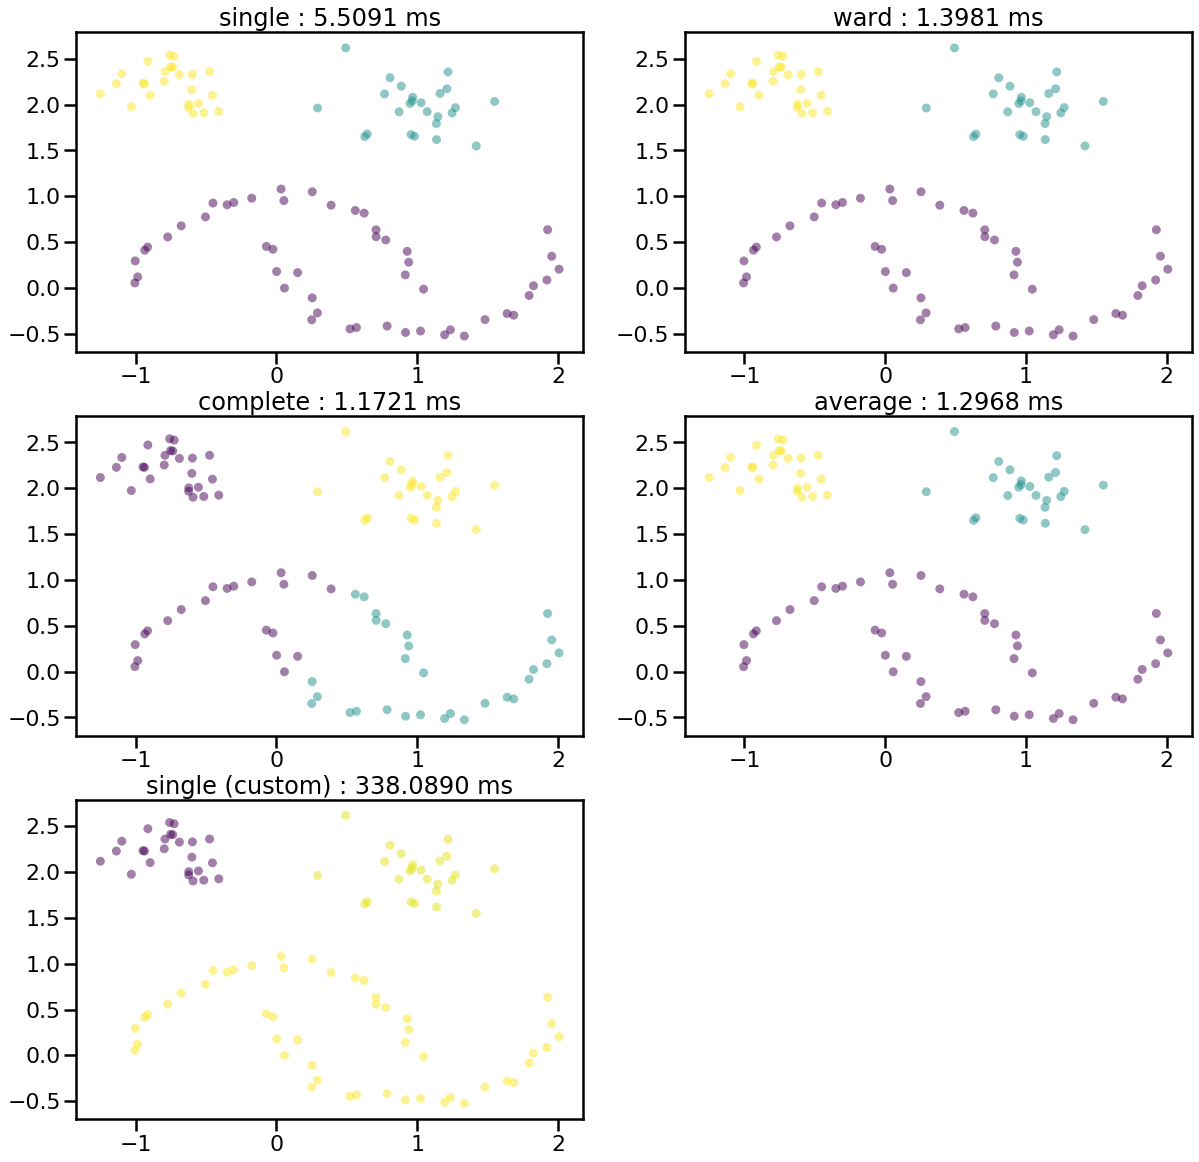

In [13]:
from sklearn.cluster import AgglomerativeClustering
plt.figure(figsize=(20,20))

methods = [AgglomerativeClustering(n_clusters=3,linkage=elt) for elt in ['single', 'ward', 'complete', 'average']] + [my_SingleLinkageAglomerativeClustering()]

for rank, method in enumerate(methods):
    plt.subplot(len(methods)//2 + len(methods)%2,2,rank+1)
    try:
        start = time.time()
        labels = method.fit_predict(test_data_0)
        end = time.time()
        plt.scatter(test_data_0.T[0], test_data_0.T[1], c=labels, **plot_kwds)
        plt.title(method.get_params()['linkage'] + ' : {:.4f} ms'.format((end-start)*1e3))
    except:
        start = time.time()
        labels = method.fit(test_data_0)
        end = time.time()
        plt.scatter(test_data_0.T[0], test_data_0.T[1], c=labels.hierarchy_[-3], **plot_kwds)
        plt.title('single (custom) : {:.4f} ms'.format((end-start)*1e3))
        
plt.show()

**Comments :** *Complete* and *Average* linkages don't perform as good as *Single* and *Ward*.

## DBSCAN

DBSCAN is a density based algorithm -- it assumes clusters for dense regions. It is also the first actual clustering algorithm we've looked at: it doesn't require that every point be assigned to a cluster and hence doesn't partition the data, but instead extracts the 'dense' clusters and leaves sparse background classified as 'noise'. In practice DBSCAN is related to agglomerative clustering. As a first step DBSCAN transforms the space according to the density of the data: points in dense regions are left alone, while points in sparse regions are moved further away. Applying single linkage clustering to the transformed space results in a dendrogram, which we cut according to a distance parameter (called epsilon or `eps` in many implementations) to get clusters. Importantly any singleton clusters at that cut level are deemed to be 'noise' and left unclustered. 

Apply it to the test_data, how do you tune the parameters?

In [15]:
class my_DBSCAN():
    
    def __init__(self, eps=1e-3, MinPts=3, metric="euclidean"):
        '''
        Attributes:
        
        eps:
            max distance between points to consider them neighbors
        MinPts:
            min number of neighbors to agglomerate the ensemble into a cluster
            NB : it doesn't consider the very point as being part of the neighborhood.
        metric_: {"euclidean","precomputed"}
            the distance to be used
            if precomputed then X is distance matrix
        labels_: integer np.array
            label assigment
        hierarchy_: list of np.array
            each array corresponds to label assigment
            at each level (number of clusters)
            hierarchy_[0]=np.array(list(range(n)))
        n_samples: integer
            number of points in our distribution
        memory: dictionnary
            allows us to keep track of the process of visiting points and there corresponding label
        Dist: np.array
            Distance matrix
        iter: integer
            Number of visited points
        '''
        self.eps = eps
        self.MinPts = MinPts
        self.metric_ = metric
        self.labels_ = None
        self.hierarchy_ = None
        self.n_samples = None
        self.memory = None
        self.Dist = None
        self.iter = None
        
        
    def memory_update(self, relative, nb_cluster):
        """
        Update the memory, labels and hierarchy values keeping track of the process.
        
        Parameters:
        -----------
        relative: integer
            The point being in the previous neighborhood and from which we expand the clustering process.
        nb_cluster: integer
            The cluster number that we aim at growing.
        
        Returns:
        -----
        self: my_DBSCAN
            Update the dbscan process features.
        """
        self.memory[relative] = nb_cluster
        self.labels_[relative] = nb_cluster
        if self.iter%50==0:
            self.hierarchy_.append(np.copy(self.labels_))
        self.iter += 1
        
        
    def class_extension(self, nb_cluster, pt):
        """
        This function aims at growing the cluster N° nb_cluster.
        It recursively calls itself with a starting point being pt.
        
        Parameters:
        -----------
        nb_cluster: integer
            The cluster number that we aim at growing.
        pt: integer
            The point that we have just incorporated in the new cluster.
        
        Returns:
        -----
        self: my_DBSCAN
            Update the dbscan process features.
        """
        # We know it is not an isolated point
        neighbors = set()
        for relative in np.where(self.Dist[pt]==True)[0]:
            neighbors.add(relative)
            
        for relative in neighbors:
            if relative not in self.memory or self.memory[relative] == -1:
                is_isolated = relative in self.memory and self.memory[relative] == -1
                self.memory_update(relative, nb_cluster)
                if not is_isolated:
                    self.class_extension(nb_cluster, relative)
                    
                    
    def fit(self, X):
        """ Create a hierarchy of clusters
        
        Parameters:
        -----------
        X: (n, p) np.array
            Data matrix
        
        Returns:
        -----
        self: my_SingleLinkageAglomerativeClustering
            to have access to labels_
        """
        # Definition of variables
        self.n_samples = X.shape[0]
        self.hierarchy_ = [np.array(range(X.shape[0]))]
        self.labels_ = np.array(range(self.n_samples))
        self.memory = {} 
        # memory will keep track of visited nodes
        # - '0' will mean that it is visited
        # - '-1' will mean that it is an outlier
        self.iter = 0
        
        if not self.metric_ == "precomputed":
            from scipy.spatial.distance import cdist
            self.Dist = cdist(X, X, self.metric_)
        else:
            self.Dist = X
            
        # We modify the Dist matrix to handle a boolean matrix which requires less memory
        self.Dist = self.Dist < self.eps
        for index in range(np.shape(self.Dist)[0]):
            self.Dist[index,index] = False # We consider that a point doesn't count as one of its neighbors
        isolated_pts = np.sum(self.Dist, axis=1) < self.MinPts
        for pt_idx in range(len(isolated_pts)):
            if isolated_pts[pt_idx]:
                self.memory_update(pt_idx, -1) # We label each point being isolated as those ones can't infer in a cluster
        
        # Iteratively create clusters
        nb_cluster = 0
        
        for node in np.where(isolated_pts==False)[0]: # We only consider non isolated points to start clusters
            if node in self.memory:
                continue
            neighbors = set()
            for relative in np.where(self.Dist[node]==True)[0]:
                neighbors.add(relative)
            
            nb_cluster += 1
            self.memory_update(node, nb_cluster)
            
            for relative in neighbors: # NB : an isolated point can be on the 'border' of the cluster
                is_isolated = relative in self.memory and self.memory[relative] == -1
                self.memory_update(relative, nb_cluster)
                if not is_isolated:
                    self.class_extension(nb_cluster, relative) # use the class extension to grow the cluster
        
            
        return self

###### Plot the graph

In [29]:
def fit_plot_dbscan(data, epsilon, min_points):
    dbscan = my_DBSCAN(eps=epsilon, MinPts=min_points)
    start = time.time()
    dbscan.fit(data)
    end = time.time()
    
    for i, label in enumerate(np.unique(dbscan.labels_)):
        if label == -1:
            note = 'Outlier'
        else:
            note = 'Cluster #{}'.format(label)
        plt.scatter(
            [t for (i, t) in enumerate(data.T[0]) if dbscan.labels_[i] == label ], 
            [t for (i, t) in enumerate(data.T[1]) if dbscan.labels_[i] == label ], 
            label=note,
            **plot_kwds)
    plt.title("my_DBSCAN; epsilon = {}; min. points = {}; cv in {:.4f} ms".format(dbscan.eps, dbscan.MinPts, (end-start)*1e3))
    #return dbscancan

###### Data_0

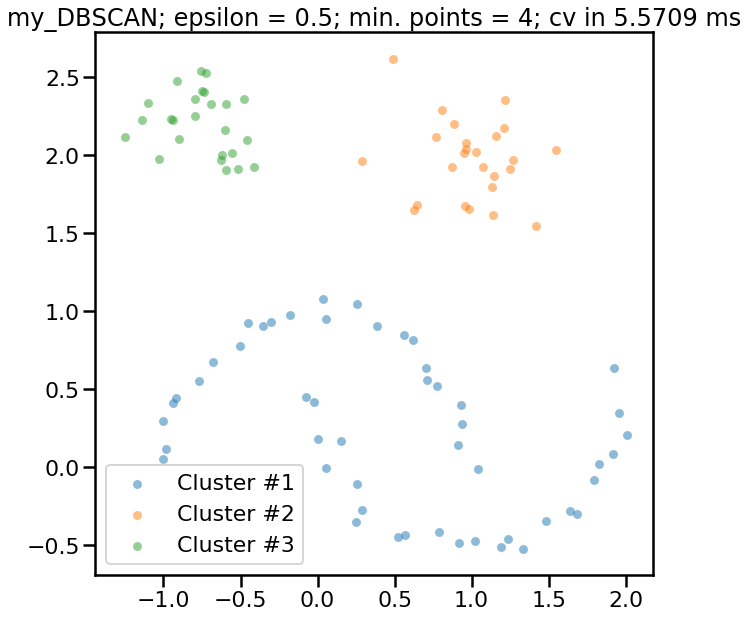

In [30]:
plt.figure(figsize=(10,10))
fit_plot_dbscan(test_data_0, epsilon=.5, min_points=4)
plt.legend()

###### Data_1

In [31]:
from scipy.spatial.distance import cdist
dbscan_args = {
    'epsilon': 0.05,
    'min_points': 50,
    'data': test_data_1
}

In [32]:
from sklearn.cluster import dbscan

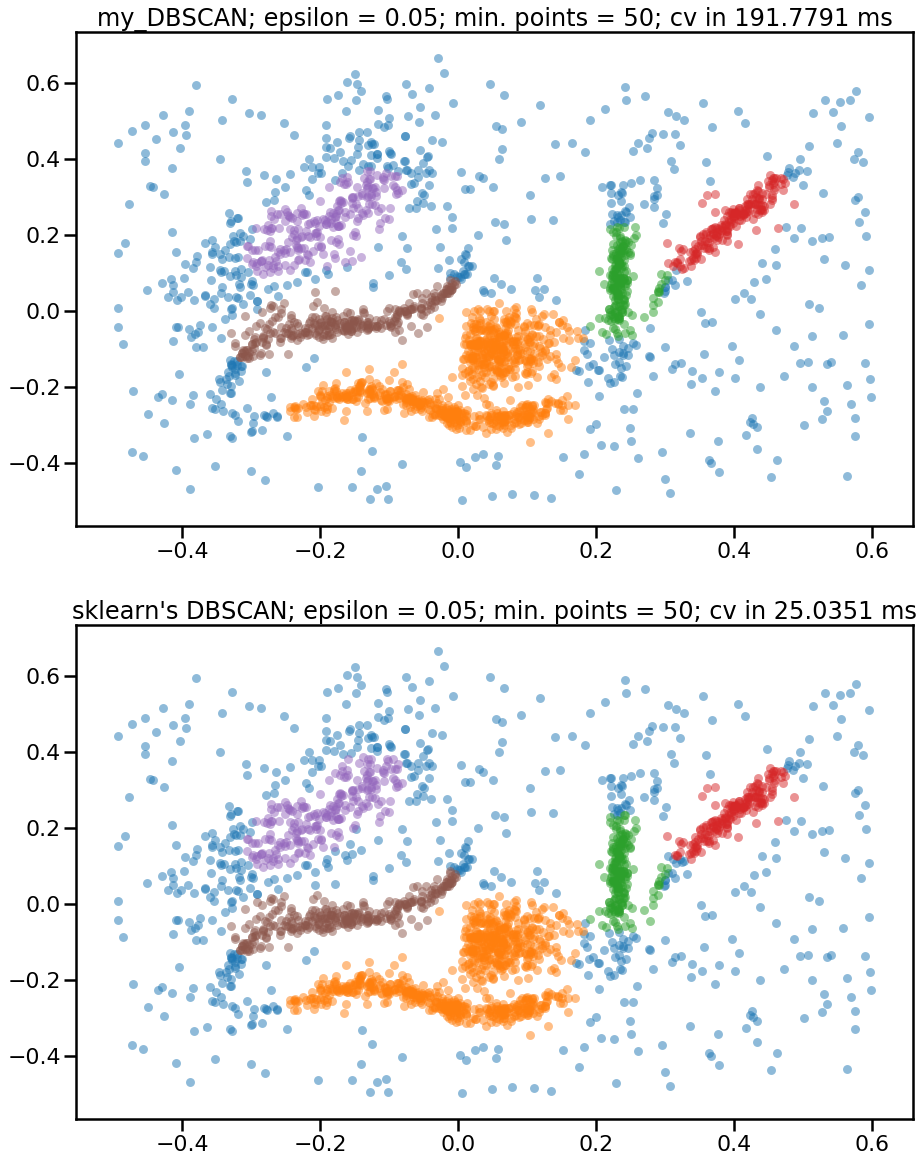

In [33]:
plt.figure(figsize=(15, 20))

plt.subplot(211)
fit_plot_dbscan(dbscan_args['data'], dbscan_args['epsilon'], dbscan_args['min_points'])

plt.subplot(212)
start = time.time()
labels = dbscan(dbscan_args['data'], eps=dbscan_args['epsilon'], min_samples=dbscan_args['min_points'], 
                metric='l2')[1]
end = time.time()

for label in np.unique(labels):
    if label == -1:
        note = 'Outlier'
    else:
        note = 'Cluster #{}'.format(label)
    plt.scatter(
                [t for (i, t) in enumerate(test_data_1.T[0]) if labels[i] == label ], 
                [t for (i, t) in enumerate(test_data_1.T[1]) if labels[i] == label ], 
                label=note,
                **plot_kwds)
    plt.title("sklearn's DBSCAN; epsilon = {}; min. points = {}; cv in {:.4f} ms".format(0.05, 50, (end-start)*1e3))



###### Gifs creator

11
10
9
8
7
6
5
4
3
2
1
it took 110.456197s to save the images.


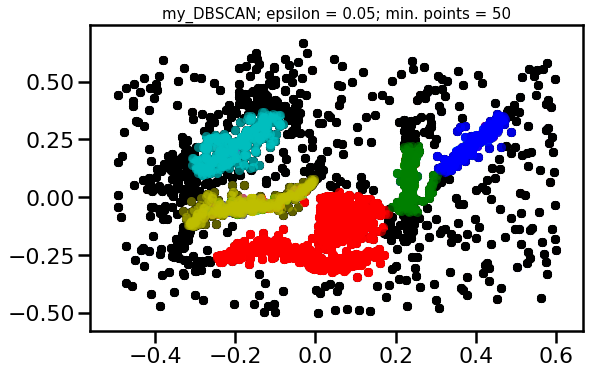

In [105]:
from scipy.spatial import distance 
from scipy.cluster.hierarchy import dendrogram

dir_name = './images'
import os
if not os.path.exists(dir_name):
    os.mkdir(dir_name)

fig = plt.figure(figsize=(8,5))
data = test_data_1

epsilon = .05
MinPts = 50
dbscan = my_DBSCAN(eps=epsilon, MinPts=MinPts)
dbscan.fit(data)
hierarchy = dbscan.hierarchy_

images=[]
colors = ['r','g','b','c','y','k','m']

beg = time.time()
for index in list(range(len(hierarchy)//5-1,0,-1)):
    # Plot and save the figure at the time index recorded by hierarchy
    for i, label in enumerate(sorted(np.unique(hierarchy[-index*5+4]))):
        plt.scatter(
            [t for (i, t) in enumerate(data.T[0]) if hierarchy[-index*5+4][i] == label ], 
            [t for (i, t) in enumerate(data.T[1]) if hierarchy[-index*5+4][i] == label ], 
            color=colors[(label-1)%len(colors)], linewidth=.1,
            **plot_kwds)
    plt.title("my_DBSCAN; epsilon = {}; min. points = {}".format(epsilon, MinPts), fontsize=15)
    
    fig.tight_layout(pad=0)
    fig.canvas.draw()
    
    # Now we can save it to a numpy array.
    fig_array = np.frombuffer(fig.canvas.tostring_rgb(), dtype=np.uint8)
    fig_array = fig_array.reshape(fig.canvas.get_width_height()[::-1] + (3,))
    
    images.append(fig_array)
    
    print(index)

    # plt.savefig('./images/img_{}.png'.format(index))
images.append(fig_array)
images.append(fig_array)
en = time.time()
print('it took {:0f}s to save the images.'.format(en-beg))


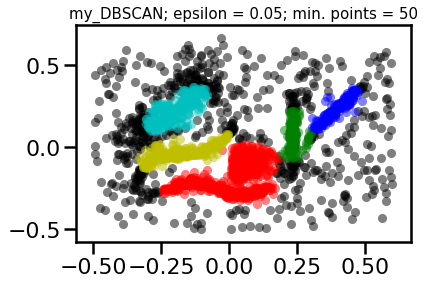

In [103]:
for i, label in enumerate(sorted(np.unique(hierarchy[-1]))):
    if label == -1:
        note = 'Outlier'
    else:
        note = 'Cluster #{}'.format(label)
    plt.scatter(
        [t for (i, t) in enumerate(data.T[0]) if hierarchy[-1][i] == label ], 
        [t for (i, t) in enumerate(data.T[1]) if hierarchy[-1][i] == label ], 
        color=colors[(label-1)%len(colors)], linewidth=.1,
        **plot_kwds)
plt.title("my_DBSCAN; epsilon = {}; min. points = {}".format(epsilon, MinPts), fontsize=15)

fig.tight_layout(pad=0)
fig.canvas.draw()

###### Plot the gif

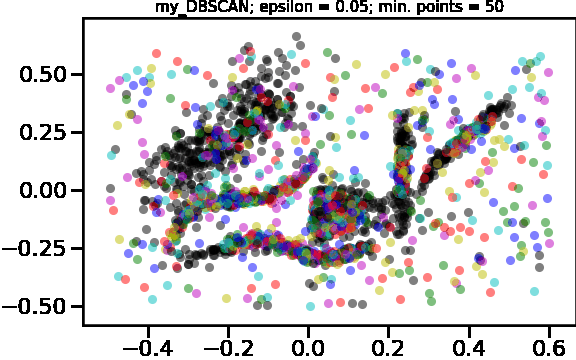

In [106]:
import os
import imageio

imageio.mimsave('/Users/emmanuel/Desktop/test_2_movie_dbscan_data1.gif', images, duration=2) # Creates the gif from all the images

from IPython.display import Image
with open('/Users/emmanuel/Desktop/test_2_movie_dbscan_data1.gif','rb') as file:
    display(Image(file.read()))

## HDBSCAN

HDBSCAN is a recent algorithm developed by some of the same people who write the original DBSCAN paper. Their goal was to allow varying density clusters. The algorithm starts off much the same as DBSCAN: we transform the space according to density, exactly as DBSCAN does, and perform single linkage clustering on the transformed space. Instead of taking an epsilon value as a cut level for the dendrogram however, a different approach is taken: the dendrogram is condensed by viewing splits that result in a small number of points splitting off as points 'falling out of a cluster'. This results in a smaller tree with fewer clusters that 'lose points'. That tree can then be used to select the most stable or persistent clusters. This process allows the tree to be cut at varying height, picking our varying density clusters based on cluster stability.

In [15]:
from sklearn.datasets import make_blobs

blob_data, _ = make_blobs(1000)

In [16]:
import hdbscan

clusterer = hdbscan.HDBSCAN(min_cluster_size=10)
cluster_labels = clusterer.fit_predict(blob_data)

C:\Users\sbran\Anaconda3\envs\aml-tp2\lib\site-packages\sklearn\externals\six.py:31: DeprecationWarning: The module is deprecated in version 0.21 and will be removed in version 0.23 since we've dropped support for Python 2.7. Please rely on the official version of six (https://pypi.org/project/six/).
  "(https://pypi.org/project/six/).", DeprecationWarning)
C:\Users\sbran\Anaconda3\envs\aml-tp2\lib\site-packages\sklearn\externals\joblib\__init__.py:15: DeprecationWarning: sklearn.externals.joblib is deprecated in 0.21 and will be removed in 0.23. Please import this functionality directly from joblib, which can be installed with: pip install joblib. If this warning is raised when loading pickled models, you may need to re-serialize those models with scikit-learn 0.21+.
  warnings.warn(msg, category=DeprecationWarning)


Text(0.5, 1.0, 'HDBSCAN demo')

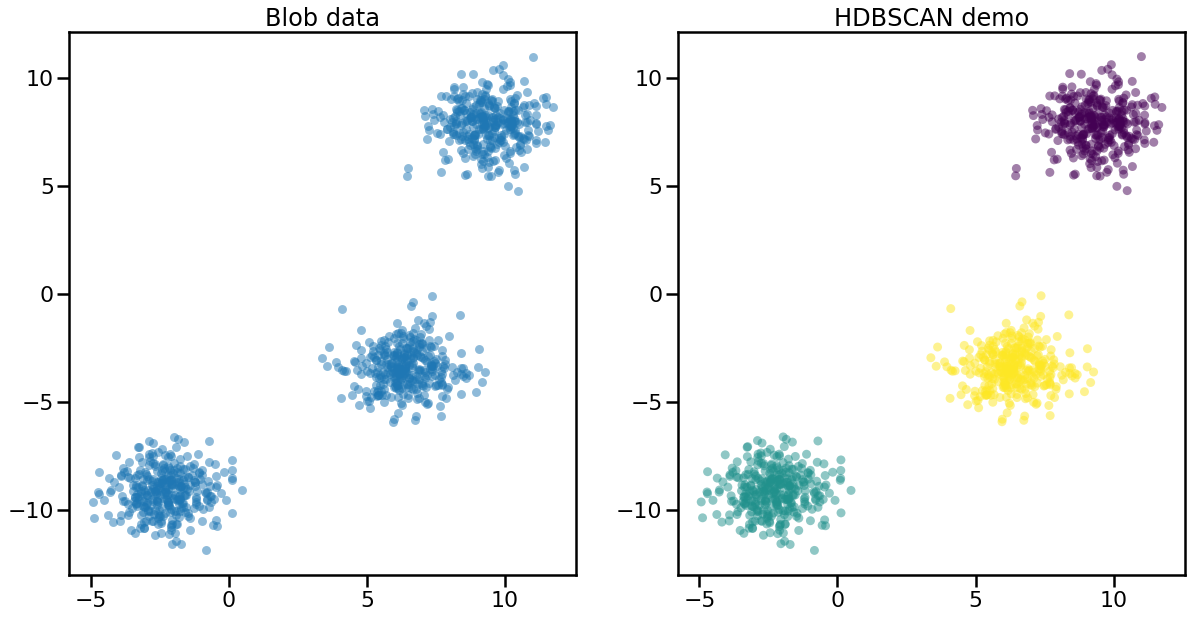

In [17]:
plt.figure(figsize=(20,10))

plt.subplot(121)
plt.scatter(blob_data.T[0], blob_data.T[1], **plot_kwds)
plt.title('Blob data')

plt.subplot(122)
plt.scatter(blob_data.T[0], blob_data.T[1], c = cluster_labels, **plot_kwds)
plt.title('HDBSCAN demo')

**Example on noised toy dataset**

In [18]:
min_cluster_size = 10
clusterer = hdbscan.HDBSCAN(min_cluster_size=min_cluster_size, algorithm='boruvka_kdtree')

hdbscan_start = time.time()
labels = clusterer.fit_predict(test_data_1)
hdbscan_end = time.time()

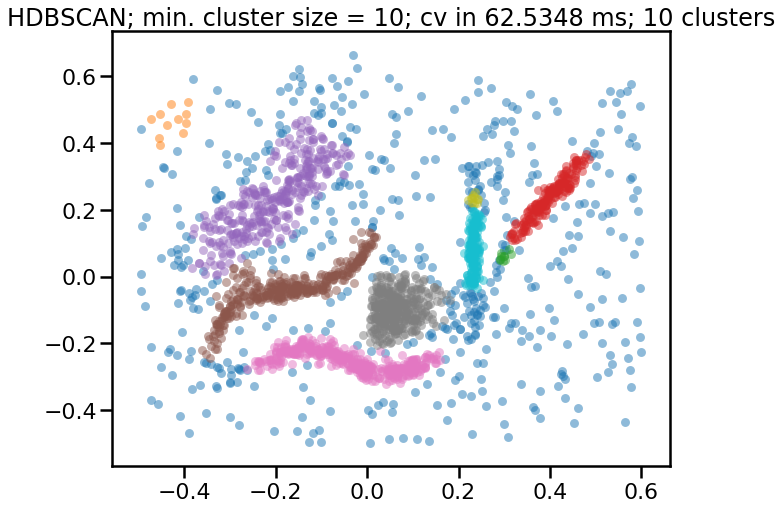

In [19]:
fig = plt.figure(figsize=(10,8))
for label in np.unique(labels):
    if label == -1:
        note = 'Outlier'
    else:
        note = 'Cluster #{}'.format(label)
    plt.scatter(
                [t for (i, t) in enumerate(test_data_1.T[0]) if labels[i] == label ], 
                [t for (i, t) in enumerate(test_data_1.T[1]) if labels[i] == label ], 
                label=note,
                **plot_kwds)
t = plt.title("HDBSCAN; min. cluster size = {}; cv in {:.4f} ms; {} clusters".format(min_cluster_size,
                                                                                 (hdbscan_end-hdbscan_start)*1e3,
                                                                                 len(np.unique(labels) - 1)))


## Apply the algorithms to the following images and comment the results

### NASA Curiosity Picture

- Look at following NASA photo taken by a robot in mars:


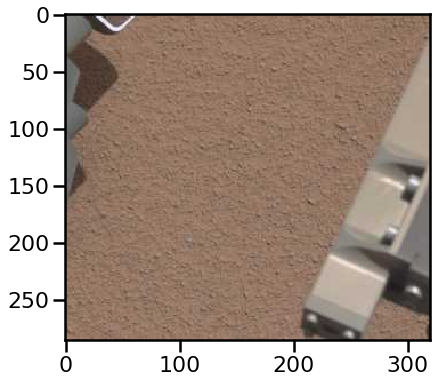

In [4]:
from PIL import Image

Im_1  = Image.open('im_nasa_reduced-1.jpg')

fig = plt.figure(figsize=(8, 6))
plt.imshow(Im_1)
plt.show()

- Transform the image to an intensity (I) and saturation (S) representation, it helps to distinguish bright and textures.

$$I=\frac{R+G+B}{3}$$
$$S=1-I\times min(R, G, B)$$

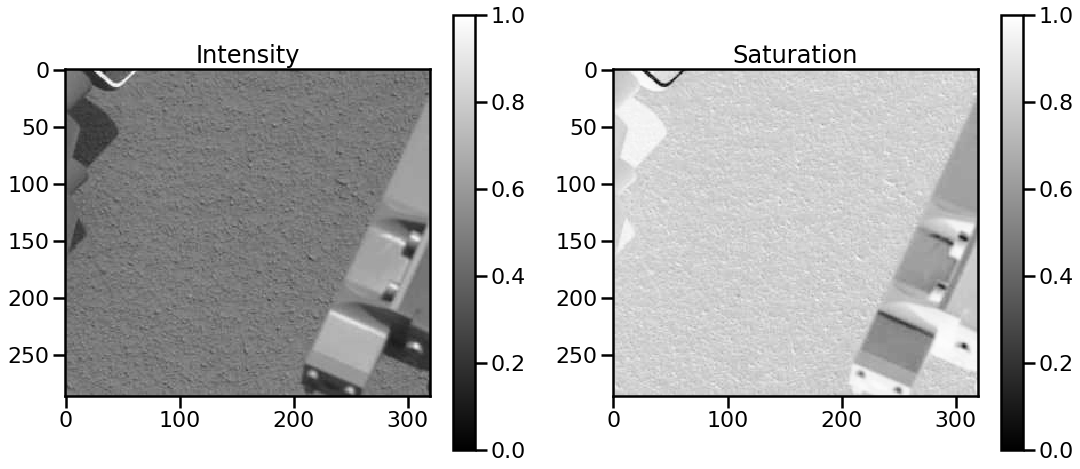

In [5]:
image = np.apply_along_axis(func1d=lambda ax: ax/255, axis=-1, arr=np.array(Im_1))
intensity = np.apply_along_axis(func1d=lambda ax: ax.sum()/3, axis=-1, arr=image)
saturation = np.apply_along_axis(func1d=lambda ax: 1 - ax.min()*ax.sum()/3, axis=-1, arr=image)

int_sat = np.apply_along_axis(func1d=lambda ax: [ax.sum()/3, 1 - ax.min()*ax.sum()/3], axis=2, arr=image)

fig = plt.figure(figsize=(18, 8))
plt.subplot(121)
plt.title("Intensity")
plt.imshow(intensity, cmap='gray', vmin=0, vmax=1)
plt.colorbar()
plt.subplot(122)
plt.title("Saturation")
plt.imshow(saturation, cmap='gray', vmin=0, vmax=1)
plt.colorbar()
plt.show()

- Apply the seen algorithms to segment the image in the Intensity-Saturation representation, comment the results and check if you find something on mars' surface. Be careful with hdbscan and memory errors for some parameters choice (use algorithm='boruvka_kdtree').

In [6]:
int_sat_1d = int_sat.reshape(int_sat.shape[0]*int_sat.shape[1] , 2)

Text(0, 0.5, 'Saturation')

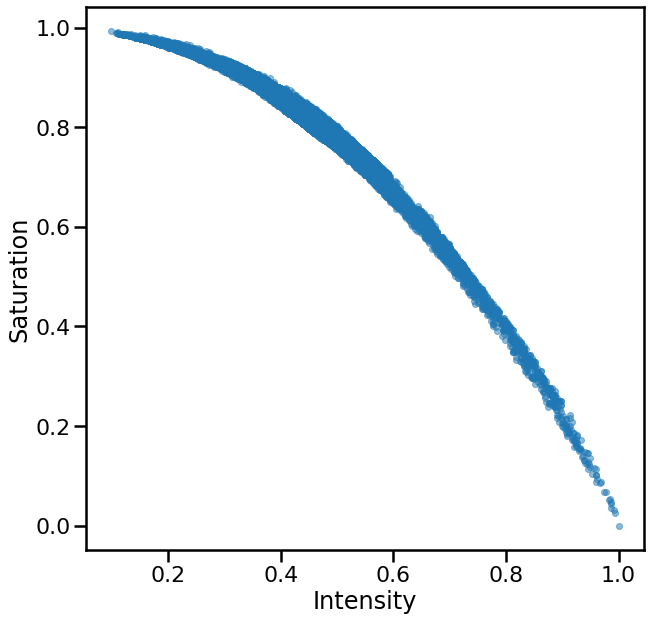

In [7]:
plt.figure(figsize=(10,10))
plt.plot(int_sat_1d[:,0], int_sat_1d[:, 1], '.', alpha=0.5)
plt.xlabel("Intensity")
plt.ylabel("Saturation")

### HDBSCAN

In [52]:
scan_args = {
    'metric': 'l2',
    'min_samples': 500,
    'eps': 0.001,
    'algorithm': 'kd_tree'
}

In [53]:
hdbscan_labels = None

In [54]:
from hdbscan import HDBSCAN

hdbscan_labels = HDBSCAN(min_cluster_size=scan_args['min_samples'], 
                        algorithm='boruvka_kdtree', allow_single_cluster=False,).fit_predict(int_sat_1d)

Text(0, 0.5, 'Saturation')

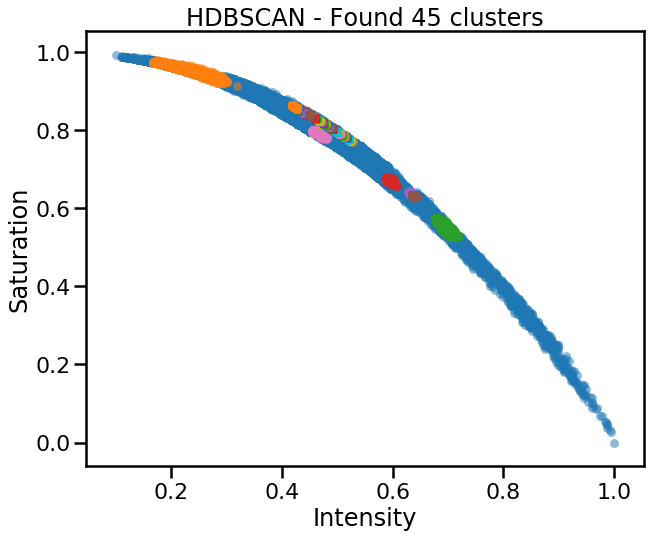

In [55]:
plt.figure(figsize=(10,8))

n_labels = len(np.unique(hdbscan_labels))
for i, label in enumerate(np.unique(hdbscan_labels)):
    if label == -1:
        note = 'Outlier'
    else:
        note = 'Cluster #{}'.format(label)

    plt.scatter([t for (j, t) in enumerate(int_sat_1d[:,0]) if hdbscan_labels[j] == label ], 
                [t for (j, t) in enumerate(int_sat_1d[:,1]) if hdbscan_labels[j] == label ], 
                label=note,
                **plot_kwds)
    plt.title("HDBSCAN - Found {} clusters".format(n_labels - 1))
plt.xlabel("Intensity")
plt.ylabel("Saturation")

In [62]:
clusters = []
n_labels = len(np.unique(hdbscan_labels))
for i, label in enumerate(np.unique(hdbscan_labels)):
    clusters.append(("Cluster #{}".format(label) if label >= 0 else "Outliers", 
                     np.array([1 if hdbscan_labels[j] == label else 0 for (j, t) in enumerate(int_sat_1d[:,0])])
                            .reshape(*int_sat.shape[:-1])))

C:\Users\sbran\Anaconda3\envs\aml-tp2\lib\site-packages\ipykernel_launcher.py:2: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  


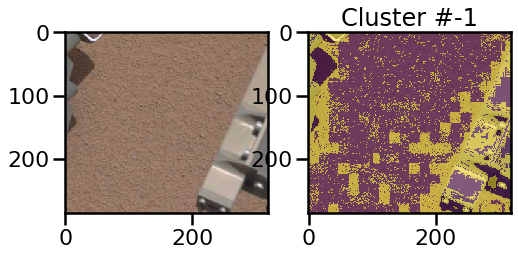

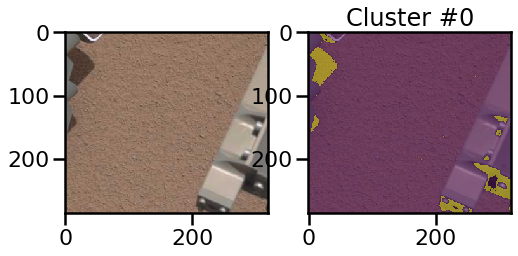

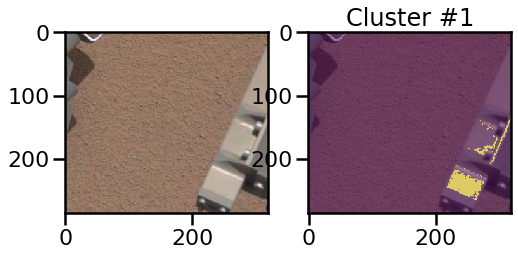

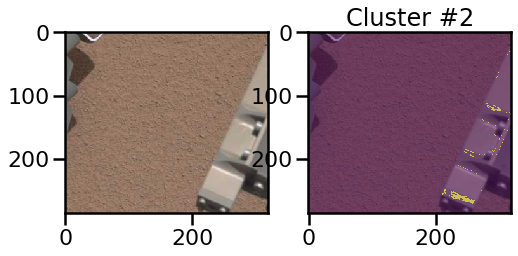

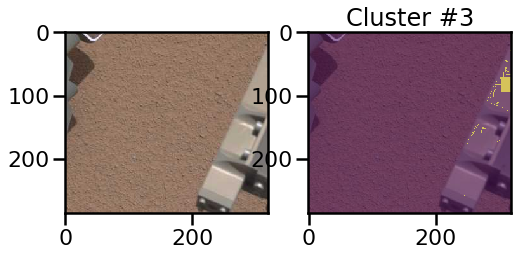

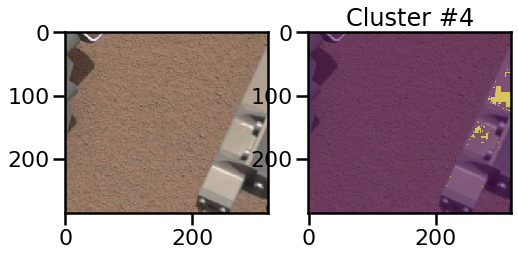

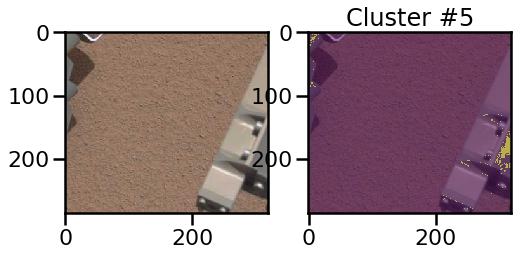

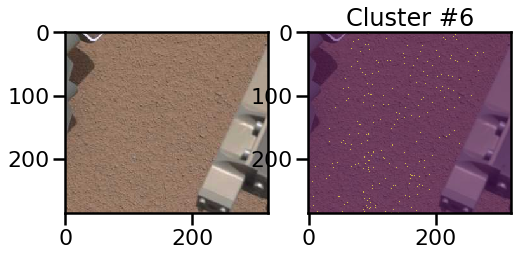

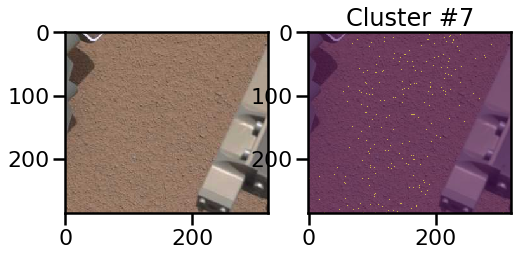

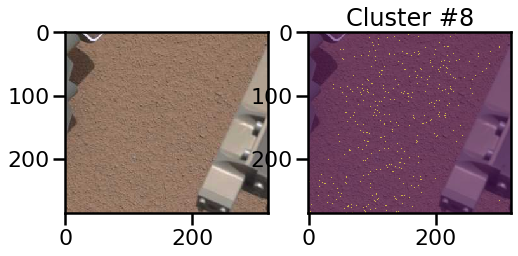

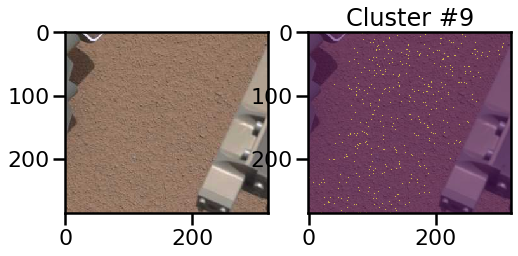

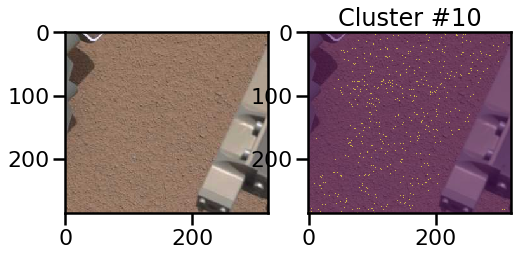

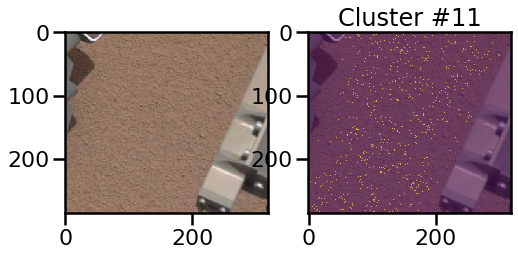

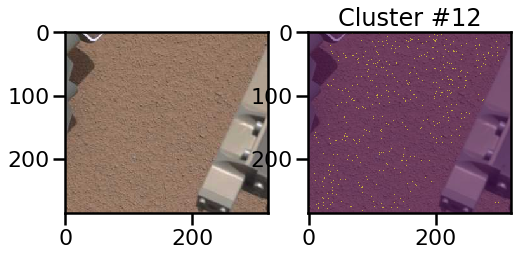

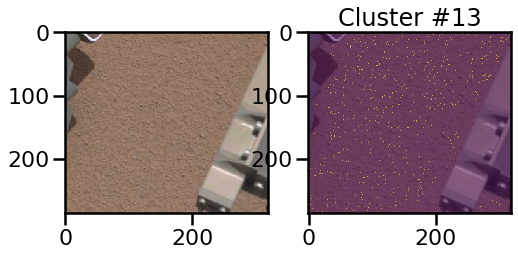

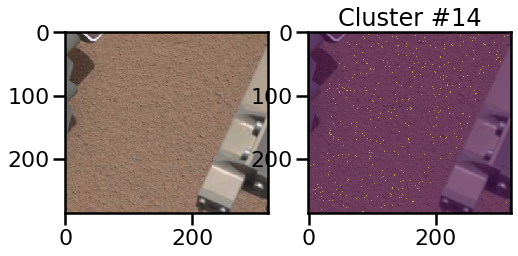

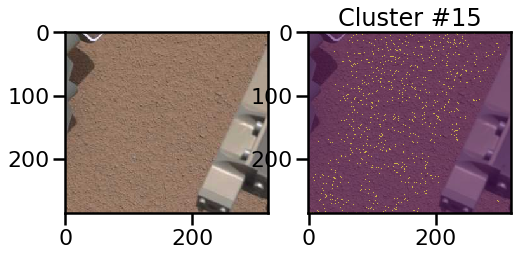

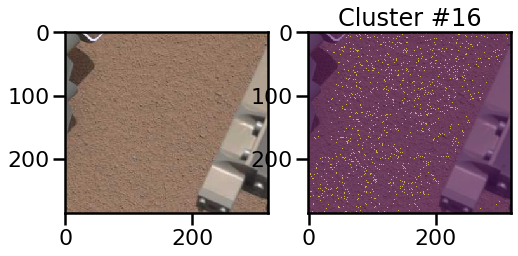

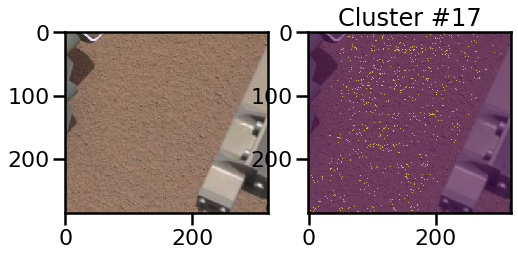

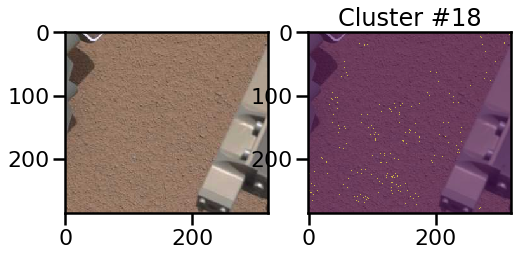

Error in callback <function flush_figures at 0x0000026801353268> (for post_execute):


KeyboardInterrupt: 

In [63]:
for (label, mask) in clusters:
    plt.figure(figsize=(8,8))
    plt.subplot(121)
    plt.imshow(Im_1)
    plt.subplot(122)
    plt.imshow(Im_1)
    plt.imshow(mask, alpha=0.5)
    plt.title(label)

### DBSCAN

In [73]:
scan_args = {
    'metric': 'l2',
    'min_samples': 1000,
    'eps': 0.01,
    'algorithm': 'kd_tree'
}

In [74]:
dbscan_labels = None

In [75]:
from sklearn.cluster import dbscan

dbscan_labels = dbscan(int_sat_1d, **scan_args)[1]

Text(0, 0.5, 'Saturation')

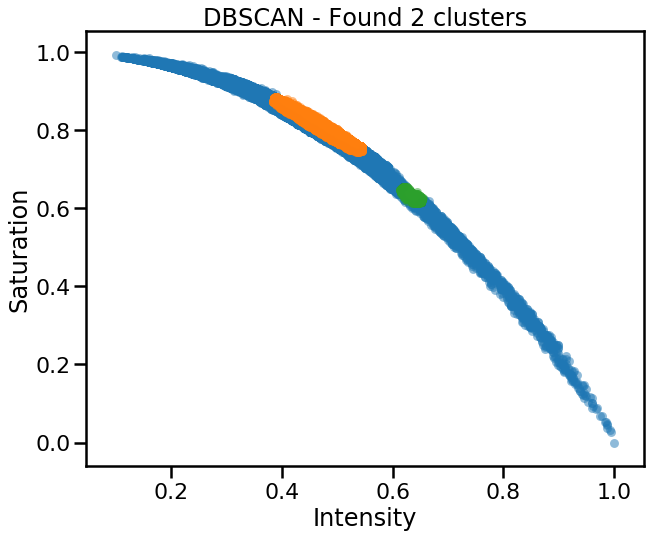

In [76]:
plt.figure(figsize=(10,8))

n_labels = len(np.unique(dbscan_labels))
for i, label in enumerate(np.unique(dbscan_labels)):
    if label == -1:
        note = 'Outlier'
    else:
        note = 'Cluster #{}'.format(label)

    plt.scatter([t for (j, t) in enumerate(int_sat_1d[:,0]) if dbscan_labels[j] == label ], 
                [t for (j, t) in enumerate(int_sat_1d[:,1]) if dbscan_labels[j] == label ], 
                label=note,
                **plot_kwds)
    plt.title("DBSCAN - Found {} clusters".format(n_labels - 1))
plt.xlabel("Intensity")
plt.ylabel("Saturation")

In [77]:
clusters = []
n_labels = len(np.unique(dbscan_labels))
for i, label in enumerate(np.unique(dbscan_labels)):
    clusters.append(("Cluster #{}".format(label) if label >= 0 else "Outliers", 
                     np.array([1 if dbscan_labels[j] == label else 0 for (j, t) in enumerate(int_sat_1d[:,0])])
                            .reshape(*int_sat.shape[:-1])))

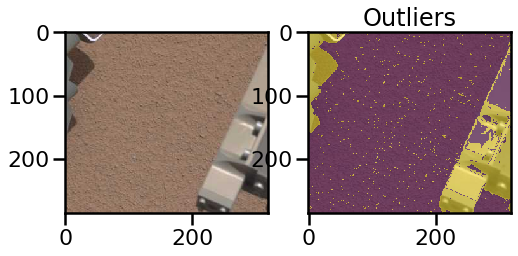

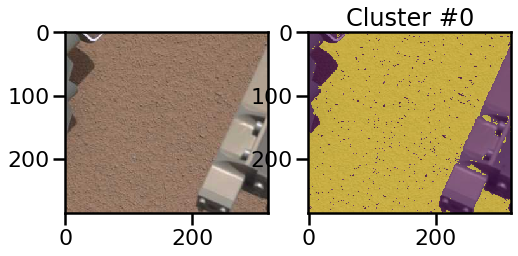

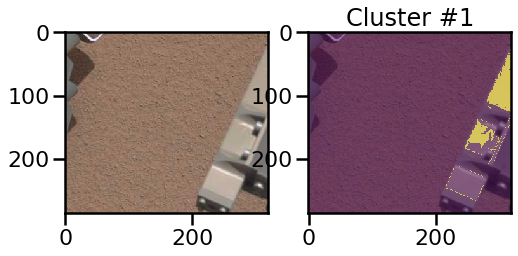

In [78]:
for (label, mask) in clusters:
    plt.figure(figsize=(8,8))
    plt.subplot(121)
    plt.imshow(Im_1)
    plt.subplot(122)
    plt.imshow(Im_1)
    plt.imshow(mask, alpha=0.5)
    plt.title(label)

### K-Means

In [29]:
from sklearn.cluster import KMeans
kmeans = KMeans(n_clusters=5, max_iter=10000).fit(int_sat_1d)

In [30]:
clusters = []
for i, label in enumerate(np.unique(kmeans.labels_)):
    clusters.append(("Cluster #{}".format(label) if label >= 0 else "Outliers", 
                     np.array([1 if kmeans.labels_[j] == label else 0 for (j, t) in enumerate(int_sat_1d[:,0])])
                            .reshape(*int_sat.shape[:-1])))

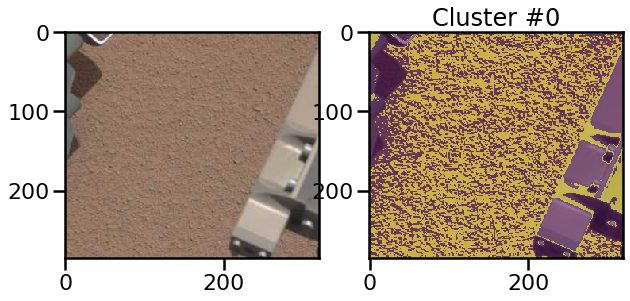

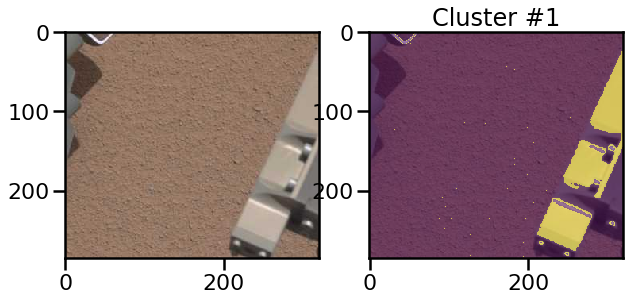

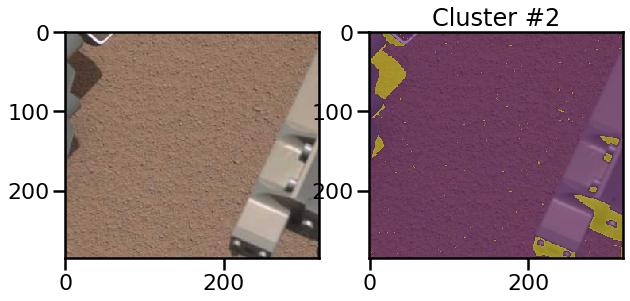

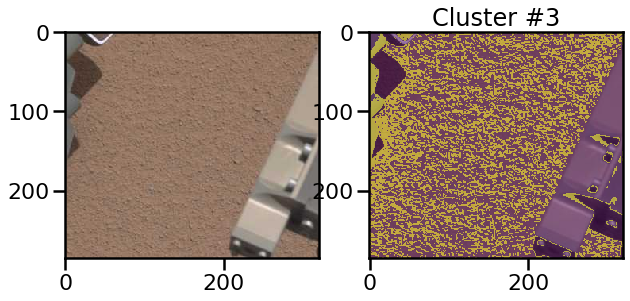

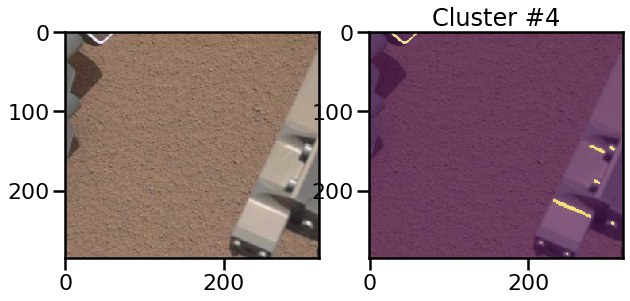

In [31]:
for (label, mask) in clusters:
    plt.figure(figsize=(10,10))
    plt.subplot(121)
    plt.imshow(Im_1)
    plt.subplot(122)
    plt.imshow(Im_1)
    plt.imshow(mask, alpha=0.5)
    plt.title(label)

### Agglomerative clustering

In [36]:
from sklearn.cluster import AgglomerativeClustering

agg_clst = AgglomerativeClustering(linkage='average', n_clusters=5, compute_full_tree=False)
agg_clst.fit_predict(int_sat_1d)

MemoryError: 

The use of Scikit Learn's Agglomerative Clustering algorithm is impossible in this use case for it raises a MemoryError exception. We haven't found a way to get rid of this issue.

HDBSCAN has disapointing performances in this use case: it uses a lot of memory and computing time for a quite low segmenting power compared to the other algorithms.

DBSCAN performs better, surely because the hyperparameters are more adequate. Similar hyper parameters could not be used with HDBSCAN, because of its very high memory usage.

KMeans has "surprisingly" good performances, both regarding image segmentation and convergence / memory use. It seems to be somehow the best algorithm for this use case, and validates the fact that Intensity and Saturation both represent quite well the textures of an image.

However, we cannot spot any hidden pattern in the texture of the Mars floor.

### Color compression

One interesting application of clustering is in color compression within images. 
For example, imagine you have an image with millions of colors.
In most images, a large number of the colors will be unused, and many of the pixels in the image will have similar or even identical colors.

Get a simplified 10-colored version of the following image by applying k-means. Plot both images.

In [102]:
from sklearn.datasets import load_sample_image
data_china = load_sample_image("china.jpg")
data_china_reshaped = data_china.reshape(-1,3)

In [103]:
from sklearn.cluster import KMeans
kmeans_0 = KMeans(n_clusters=10, max_iter=10000).fit(data_china_reshaped)

In [104]:
tenc_china = np.apply_along_axis(lambda l: kmeans_0.cluster_centers_[l], axis=0, arr=np.array(kmeans_0.labels_)).reshape(data_china.shape[0], data_china.shape[1], 3)

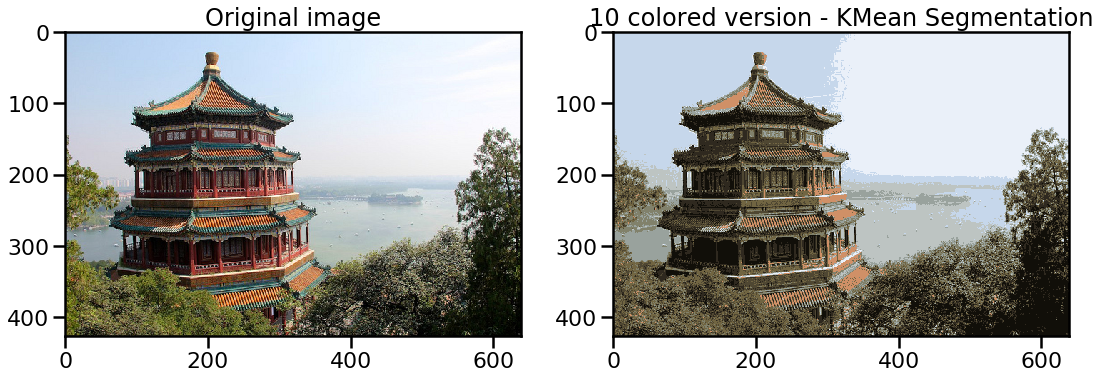

In [105]:
fig = plt.figure(figsize=(18, 18))

plt.subplot(2,2,1)
plt.imshow(data_china)
plt.title('Original image')

plt.subplot(2,2,2)
plt.imshow(np.apply_along_axis(lambda cls: [int(cls[0]), int(cls[1]), int(cls[2])], 
                               arr=tenc_china, axis=-1))
plt.title('10 colored version - KMean Segmentation')

plt.show()

We have decided to plot the 10 colored version of the image not using random colors but using the colors of the 10 centroids of the clusters. We observe that the reconstructed image is very similar to the original one even though it only contains 10 different colors. This shows a *N I C E* application of clustering to compression.

**TODO** - It would be very interesting to compare the size in bytes of each of the two images in a conventional format (eg JPEG).